During this data analysis, a dataset of online shopping website activity (each row representing details about one user while being on the website) will be extracted from RDS database, cleaned using various statistical methods, then will be analysed to answer some questions which will contribute to make informed decisions about changes to the website and marketing strategies.

Import required packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import required modules:

In [2]:
import db_utils
import datatype_transform
import dataframe_transform
import dataframe_info
import plotter

Import data from RDS database:

In [3]:
customer_activity_class = db_utils.RDSDatabaseConnector(db_utils.yaml_dictionary)
engine = customer_activity_class.connect_database()
customer_activity = customer_activity_class.extract_data(engine)

Convert data types:

In [6]:
# Get the data type for each column
print('Data types before the transformation:')
print(customer_activity.dtypes)
         
# Convert data types for some columns to category
columns_to_transform = ['administrative', 'product_related', 'informational', 
                        'month', 'operating_systems', 'browser', 'region', 
                        'traffic_type', 'visitor_type']
for column in columns_to_transform:
    customer_activity_DataTransform.convert_to_category(column)
    
# Check if the columns have been transformed correctly  
print('\n')  
print('Data types after the transformation:')
print(customer_activity.dtypes)

Data types before the transformation:
administrative              float64
administrative_duration     float64
informational                 int64
informational_duration      float64
product_related             float64
product_related_duration    float64
bounce_rates                float64
exit_rates                  float64
page_values                 float64
month                        object
operating_systems            object
browser                      object
region                       object
traffic_type                 object
visitor_type                 object
weekend                        bool
revenue                        bool
dtype: object


Data types after the transformation:
administrative              category
administrative_duration      float64
informational               category
informational_duration       float64
product_related             category
product_related_duration     float64
bounce_rates                 float64
exit_rates                   float64
p

Following columns have been converted to category data type:
- administrative
- informational
- product_related
- month
- operating_systems
- browser
- region
- traffic_type
- visitor_type

Put columns into different groups based on data types:

In [7]:
all_columns = customer_activity.columns
numeric_columns = ['administrative_duration', 'informational_duration', 'product_related_duration',
                   'bounce_rates', 'exit_rates', 'page_values']
categorical_columns = ['administrative', 'informational', 'month',
                       'operating_systems', 'browser', 'region', 'visitor_type']
boolean_columns = ['weekend', 'revenue']

Create instances of the classes:

In [8]:
customer_activity_info = dataframe_info.DataFrameInfo(customer_activity)
customer_activity_plot = plotter.Plotter(customer_activity)
customer_activity_transform = dataframe_transform.DataFrameTransform(customer_activity)

Get statistical summaries for numeric columns:

In [9]:
customer_activity_info.get_description()

# Get median as well
for column in numeric_columns:
    customer_activity_info.get_median(column)

Description for numeric columns:
       administrative_duration  informational_duration  \
count             11418.000000            11994.000000   
mean                 84.539079               34.486687   
std                 179.392485              136.201557   
min                   0.000000                0.000000   
25%                   0.000000                0.000000   
50%                   6.000000                0.000000   
75%                  95.000000                0.000000   
max                2155.000000             1988.750000   

       product_related_duration  bounce_rates    exit_rates   page_values  
count              12129.000000  12330.000000  12330.000000  12330.000000  
mean                1192.426086      0.022381      0.042820      5.556310  
std                 1767.243802      0.048847      0.048578     17.397345  
min                    0.000000      0.000000      0.000000      0.000000  
25%                  192.000000      0.000000      0.014000     

For categorical columns and boolean columns, get distinct count values for each column and plot bar charts:

Counts for distinct values for administrative
administrative  counts  percentage
           0.0    5644       47.99
           1.0    1237       10.52
           2.0    1018        8.66
           3.0     885        7.53
           4.0     661        5.62
           5.0     541        4.60
           6.0     401        3.41
           7.0     314        2.67
           8.0     259        2.20
           9.0     227        1.93
          10.0     165        1.40
          11.0      97        0.82
          12.0      93        0.79
          13.0      65        0.55
          14.0      42        0.36
          15.0      37        0.31
          16.0      25        0.21
          17.0      15        0.13
          18.0      14        0.12
          19.0       5        0.04
          21.0       5        0.04
          23.0       4        0.03
          24.0       4        0.03
          20.0       2        0.02


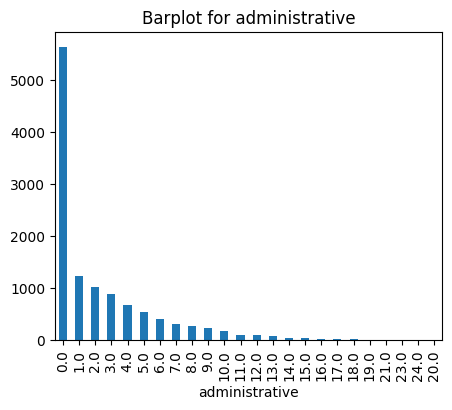

Counts for distinct values for informational
informational  counts  percentage
            0    9595       77.82
            1    1105        8.96
            2     763        6.19
            3     426        3.45
            4     215        1.74
            5     101        0.82
            6      74        0.60
            7      26        0.21
            8      12        0.10
            9       6        0.05
           12       4        0.03
           10       2        0.02
           11       1        0.01


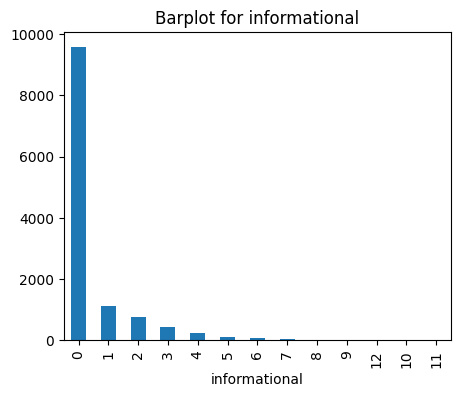

Counts for distinct values for month
month  counts  percentage
  May    3332       27.02
  Nov    2959       24.00
  Dec    1828       14.83
  Mar    1807       14.66
  Oct     598        4.85
  Sep     462        3.75
  Aug     457        3.71
  Jul     441        3.58
 June     247        2.00
  Feb     199        1.61


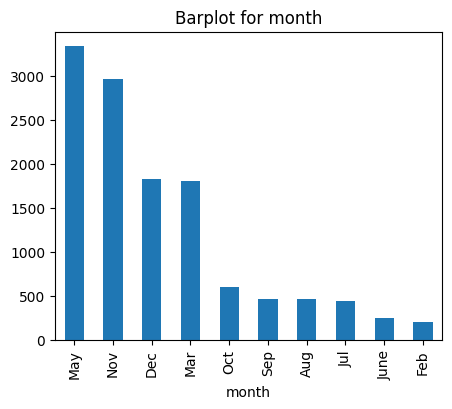

Counts for distinct values for operating_systems
operating_systems  counts  percentage
          Windows    6596       53.54
            MACOS    2676       21.72
          Android    2584       20.98
              iOS     385        3.13
         ChromeOS      62        0.50
           Ubuntu       9        0.07
            Other       7        0.06


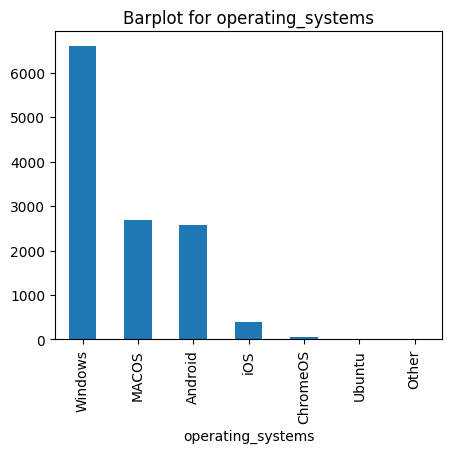

Counts for distinct values for browser
          browser  counts  percentage
    Google Chrome    7721       62.62
           Safari    2527       20.49
  Mozilla Firefox     830        6.73
   Microsoft Edge     582        4.72
Internet Explorer     156        1.27
 Samsung Internet     145        1.18
            Opera     136        1.10
          Android     121        0.98
               QQ      53        0.43
   Sogou Explorer      47        0.38
           Yandex       8        0.06
       UC Browser       2        0.02
     Undetermined       2        0.02


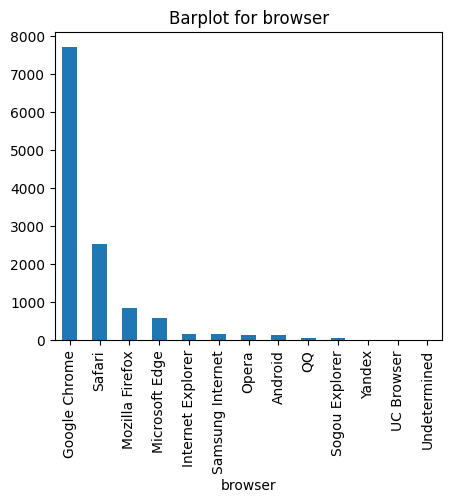

Counts for distinct values for region
         region  counts  percentage
  North America    4869       39.49
 Western Europe    2283       18.52
 Eastern Europe    1154        9.36
           Asia    1143        9.27
  South America     913        7.40
         Africa     770        6.24
Northern Africa     499        4.05
Southern Africa     423        3.43
        Oceania     276        2.24


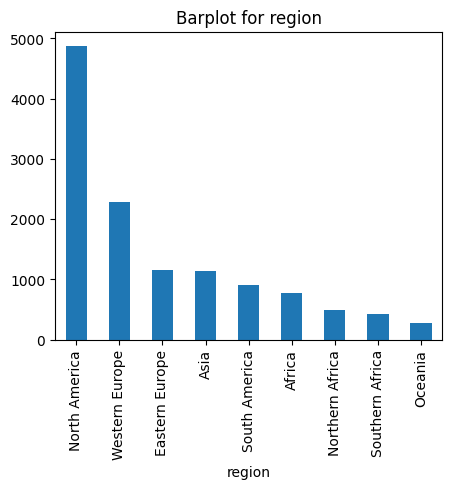

Counts for distinct values for visitor_type
     visitor_type  counts  percentage
Returning_Visitor   10691       86.71
      New_Visitor    1570       12.73
            Other      69        0.56


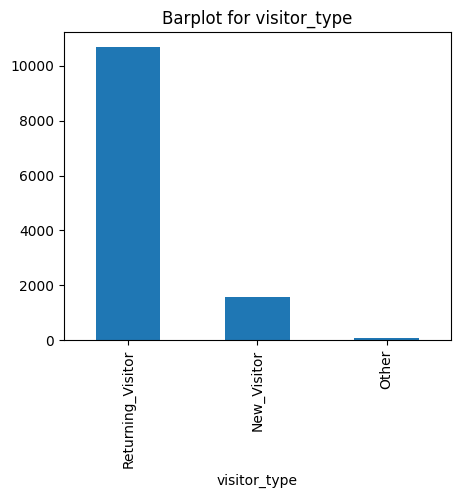

Counts for distinct values for weekend
 weekend  counts  percentage
   False    9785       79.36
    True    2545       20.64


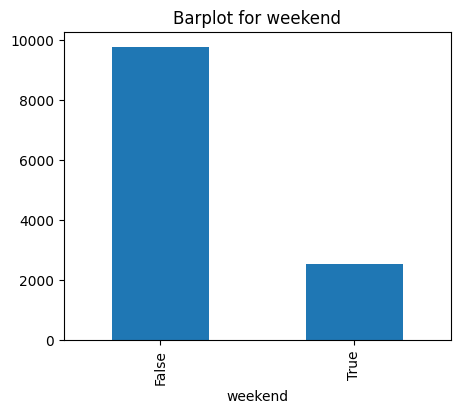

Counts for distinct values for revenue
 revenue  counts  percentage
   False   10421       84.52
    True    1909       15.48


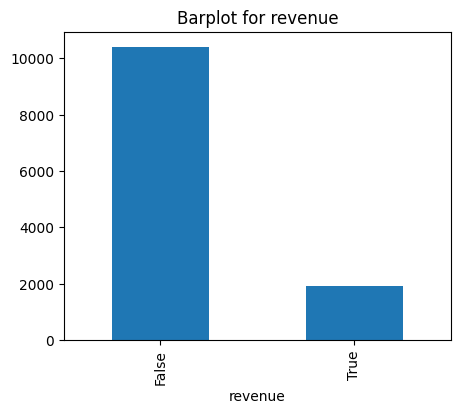

In [10]:
for column in categorical_columns:
    customer_activity_info.get_counts(column)
    customer_activity_plot.plot_counts(column)    
    
for column in boolean_columns:
    customer_activity_info.get_counts(column)
    customer_activity_plot.plot_counts(column)

product_related column has been omitted as there are too many categories.

Get information for the amount of missing values in each column:

In [11]:
for column in all_columns:
    customer_activity_info.get_NULL_counts(column)

Number of NULLs for administrative: 570
Percentage of NULLs for administrative: 4.62 %
Number of NULLs for administrative_duration: 912
Percentage of NULLs for administrative_duration: 7.4 %
Number of NULLs for informational: 0
Percentage of NULLs for informational: 0.0 %
Number of NULLs for informational_duration: 336
Percentage of NULLs for informational_duration: 2.73 %
Number of NULLs for product_related: 579
Percentage of NULLs for product_related: 4.7 %
Number of NULLs for product_related_duration: 201
Percentage of NULLs for product_related_duration: 1.63 %
Number of NULLs for bounce_rates: 0
Percentage of NULLs for bounce_rates: 0.0 %
Number of NULLs for exit_rates: 0
Percentage of NULLs for exit_rates: 0.0 %
Number of NULLs for page_values: 0
Percentage of NULLs for page_values: 0.0 %
Number of NULLs for month: 0
Percentage of NULLs for month: 0.0 %
Number of NULLs for operating_systems: 11
Percentage of NULLs for operating_systems: 0.09 %
Number of NULLs for browser: 0
Percen

Following columns contain missing values:
- administrative
- administrative_duration
- informational_duration
- product_related
- product_related_duration
- operating_systems

For categorical columns (administrative, product_realted, and operating_systems),
mode imputation will be used.
For numeric columns (administrative_duration, informational_duration, and product_related_duration) if
it is skewed median imputation will be used and if it is symmetrical mean 
imputation will be used.

Check the skewness for these three numeric columns with missing values:

In [12]:
numeric_columns_missing_values = ['administrative_duration', 'informational_duration', 'product_related_duration']
for column in numeric_columns_missing_values:
    customer_activity_info.get_skewness(column)

Skew of administrative_duration is 4.67
Skew of informational_duration is 7.2
Skew of product_related_duration is 3.64


They are all right skewed so median imputation will be conducted:

In [13]:
# Compute median imputation for the numeric columns with missing values
for column in numeric_columns_missing_values:
    customer_activity_transform.median_impute(column)
    
# Compute mode imputation for the categorical columns with missing values
categorical_columns_missing_values = ['administrative', 'product_related', 'operating_systems']
for column in categorical_columns_missing_values:
    customer_activity_transform.mode_impute(column)
    
# Check if the imputation has been successful
columns_missing_values = numeric_columns_missing_values + categorical_columns_missing_values
for column in columns_missing_values:
    customer_activity_info.get_NULL_counts(column)

Number of NULLs for administrative_duration: 0
Percentage of NULLs for administrative_duration: 0.0 %
Number of NULLs for informational_duration: 0
Percentage of NULLs for informational_duration: 0.0 %
Number of NULLs for product_related_duration: 0
Percentage of NULLs for product_related_duration: 0.0 %
Number of NULLs for administrative: 0
Percentage of NULLs for administrative: 0.0 %
Number of NULLs for product_related: 0
Percentage of NULLs for product_related: 0.0 %
Number of NULLs for operating_systems: 0
Percentage of NULLs for operating_systems: 0.0 %


Get information for skewness for all numeric columns:

In [14]:
for column in numeric_columns:
    customer_activity_info.get_skewness(column)

Skew of administrative_duration is 4.84
Skew of informational_duration is 7.3
Skew of product_related_duration is 3.68
Skew of bounce_rates is 2.95
Skew of exit_rates is 2.19
Skew of page_values is 6.02


Plot histograms to visualise the skewness:

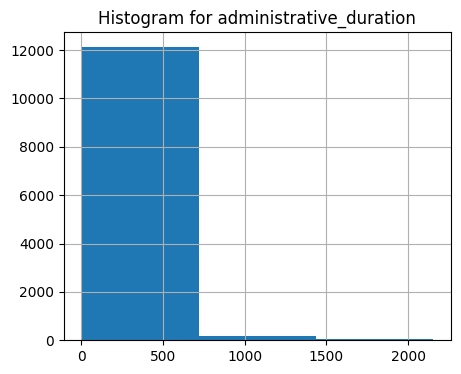

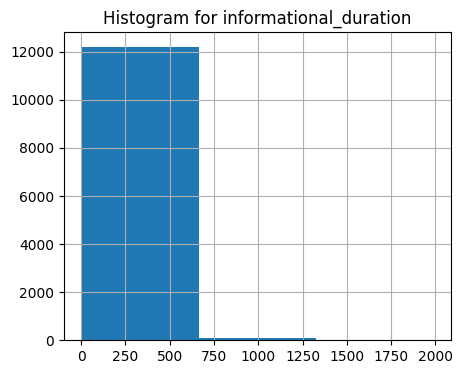

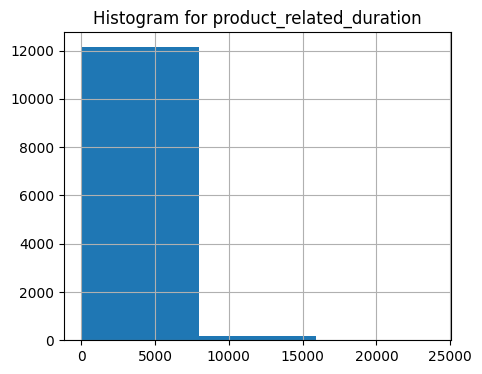

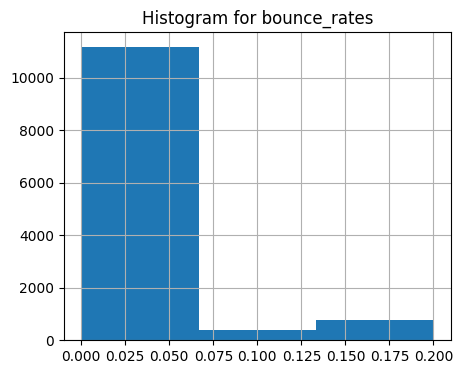

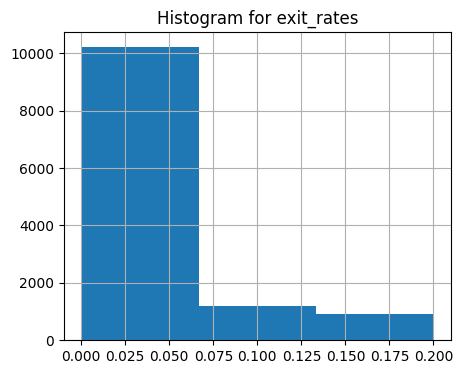

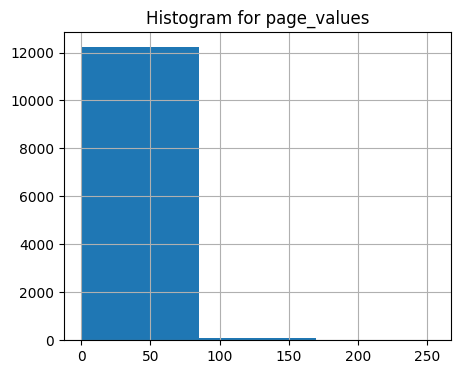

In [15]:
for index, column in enumerate(numeric_columns):
    customer_activity_plot.plot_histograms(column)

Conduct Yeo-Johnson transform on the numeric columns:

In [16]:
for column in numeric_columns:
    customer_activity_transform.yeo_johnson_transform(column)
    
# Check the skewness again
for column in numeric_columns:
    customer_activity_info.get_skewness(column)

Skew of administrative_duration is 0.16
Skew of informational_duration is 1.51
Skew of product_related_duration is -0.03
Skew of bounce_rates is 1.02
Skew of exit_rates is 0.42
Skew of page_values is 1.35


Get z_scores for numeric columns to find outliers:

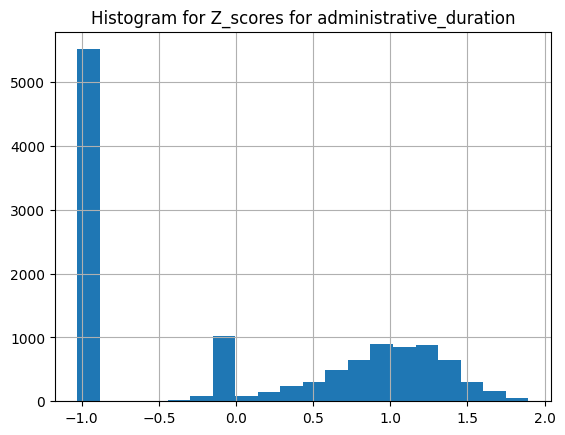

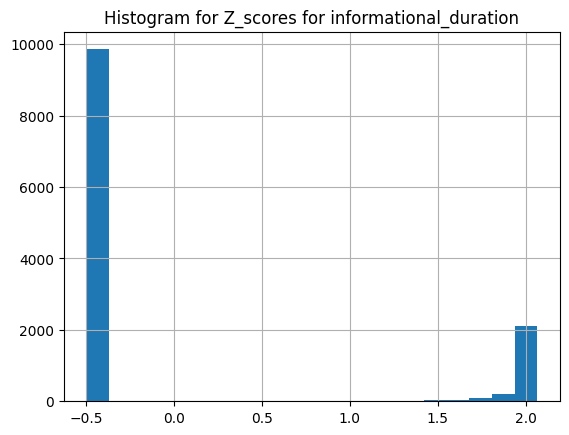

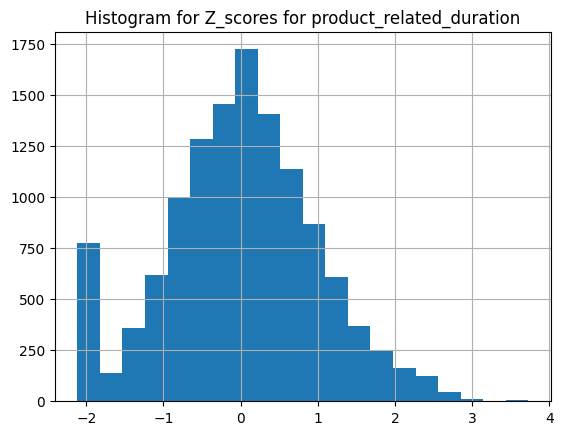

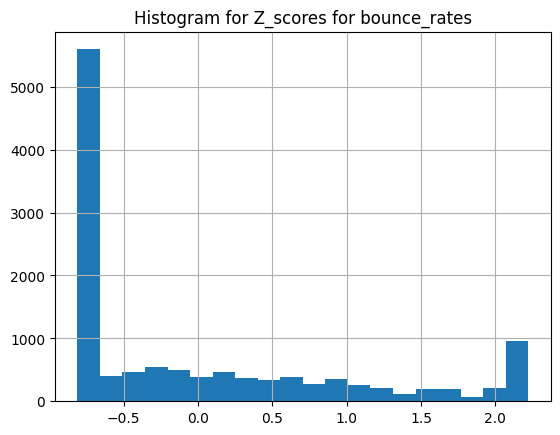

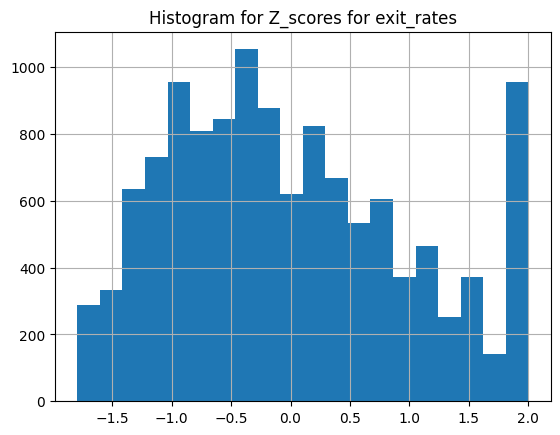

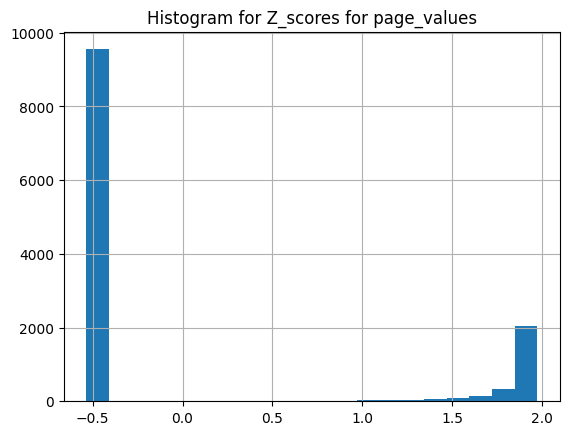

In [15]:
z_scores = {}
for column in numeric_columns:
    z_scores[column] = customer_activity_info.get_zscores(column)
    
# Plot histograms for z_scores for each numeric column
for column in z_scores:
    pd.Series(z_scores[column]).hist(bins = 20)
    plt.title(f'Histogram for Z_scores for {column}')
    plt.show()
    
    

If we consider z_scores greater than +3 or less then -3 as outliers, only product_related_duration
column contains a small number of outliers which will be dropped. 

In [17]:
# Get z_scores for product_related_duration column
product_related_duration_zscores = customer_activity_info.get_zscores('product_related_duration')

# Get shape for the DataFrame before the conversion
print('Shape of the DataFrame before removing the outliers:', customer_activity.shape)

# Add it to the DataFrame as a new column
customer_activity['z_scores'] = product_related_duration_zscores

# Drop outliers from the DataFrame
customer_activity_transform.drop_outliers('z_scores')

# Drop the z_scores column from the DataFrame
customer_activity_transform.drop_column('z_scores')

# Check the shape of the DataFrame after the conversion
print('Shepe of the DataFrame after removing outliers:', customer_activity.shape)


Shape of the DataFrame before removing the outliers: (12330, 17)
Shepe of the DataFrame after removing outliers: (12321, 17)


Check for collinearity:

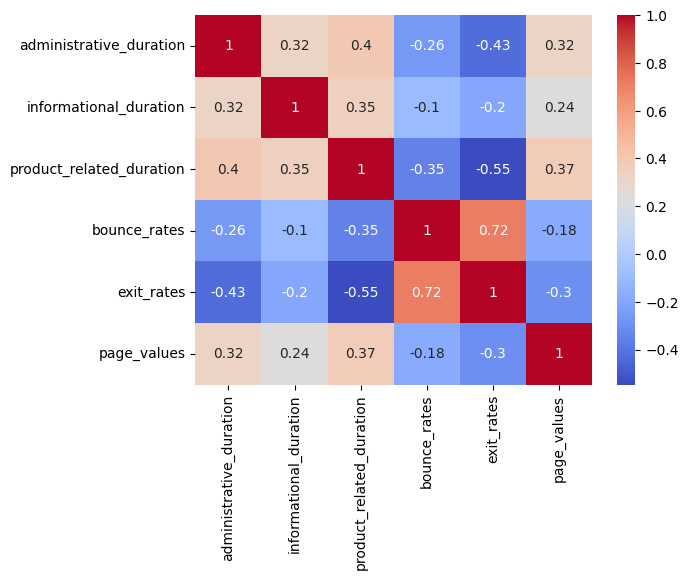

In [18]:
# Create a new DataFrame with only numeric values
numeric_df = customer_activity[numeric_columns]
numeric_df_plotter = plotter.Plotter(numeric_df)
numeric_df_plotter.plot_correlation_matrix()

There does not seem to be any issues with collineaity on this DataFrame.

The cleaned DataFrame will be analysed to answer questions in following sections:
- *S1 - General overview of the performance of the website*
- *S2 - Which softwares customers are using to visit the website*
- *S3 - Investigate the traffic coming to the website*
- *S4 - Where the website revenue is being generated*

*S1Q1: Are sales proportionally happening more on weekends?*

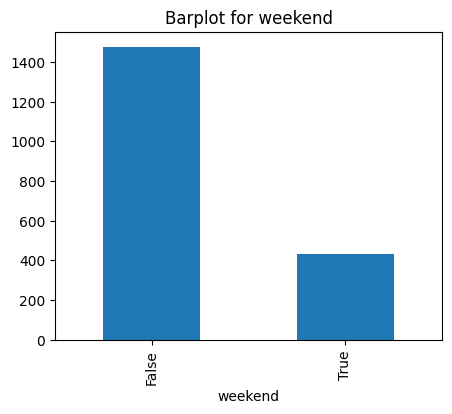

In [19]:
# Filter the DataFrame for rows where revenue is True (the customer purachesed during that session) 
revenue_true = customer_activity[customer_activity['revenue'] == True]

# Create a new class instance for the filtered DataFrame
revenue_true_plot = plotter.Plotter(revenue_true)

# Plot a bar chart for the weekend column
revenue_true_plot.plot_counts('weekend')

No, for the activities only took during the weekend, the amount of sales is small.

*S1Q2: Which regions are generating the most revenue currently?*

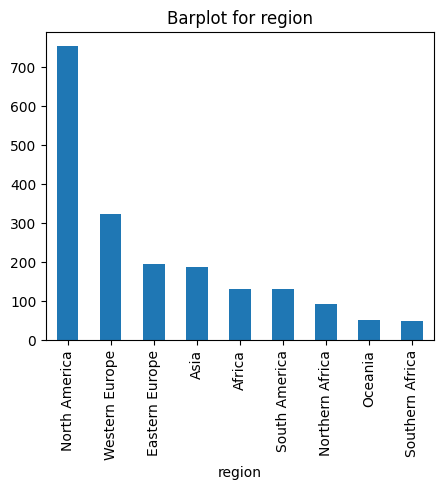

In [20]:
# Plot a bar chart for the region column
revenue_true_plot.plot_counts('region')

North America is generating the most revenue, followed by Western Europe.

*S1Q3: Is there any particular website traffic that stands out when generating sales?*

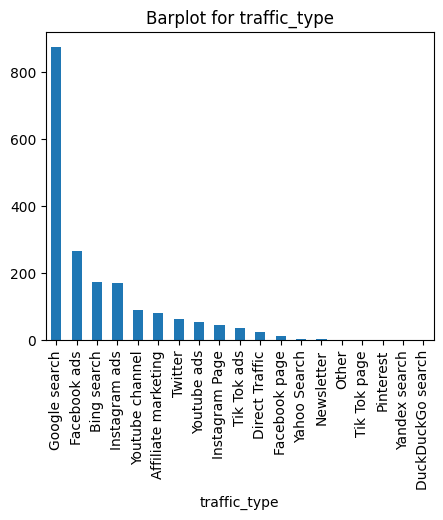

In [21]:
# Plot a bar chart for traffic type column 
revenue_true_plot.plot_counts('traffic_type')

Yes, Google search stands out.

*S1Q4: What percentage of time is spent on the website performing administrative/product or informational related tasks?*

In [22]:
# Get total hours for administrative/product or unformational related tasks
administrative_total = customer_activity['administrative_duration'].sum()
informational_total = customer_activity['informational_duration'].sum()
product_related_total = customer_activity['product_related_duration'].sum()
total_time = administrative_total + informational_total + product_related_total
data = [['Administrative', administrative_total, round(administrative_total / total_time * 100, 2)], 
        ['Informational', informational_total, round(informational_total / total_time * 100, 2)],
        ['Product related', product_related_total, round(product_related_total / total_time * 100, 2)]]

print(pd.DataFrame(data, columns = ['Tasks', 'Total time', 'Percentage']))


             Tasks     Total time  Percentage
0   Administrative   21583.544947       10.75
1    Informational    2206.026889        1.10
2  Product related  177022.520263       88.15


88% of time spent on product related tasks, 11% on administrative tasks, and 1% on product related tasks.

*S1Q5: Are there any informational/administrative tasks which users spend time doing most?*

In [23]:
# Create a DataFrame with informational and informational_duration columns
informational_df = customer_activity[['informational', 'informational_duration']]

# Group by the informational categories and get sum for duration for each category
print(informational_df.groupby(['informational']).sum())

# Do the same for administrative tasks
administrative_df = customer_activity[['administrative', 'administrative_duration']]
print(administrative_df.groupby(['administrative']).sum())

               informational_duration
informational                        
0                            1.214515
1                          796.850842
2                          649.189877
3                          370.773623
4                          192.282333
5                           87.668049
6                           65.903050
7                           21.945791
8                           11.016854
9                            5.506067
10                           0.919683
11                           0.918248
12                           1.837957
                administrative_duration
administrative                         
0.0                         1823.636076
1.0                         3090.597010
2.0                         3043.329618
3.0                         2864.740712
4.0                         2227.793562
5.0                         1868.000960
6.0                         1443.647790
7.0                         1141.152087
8.0                          9

C:\Users\madok\AppData\Local\Temp\ipykernel_11764\4114692143.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(informational_df.groupby(['informational']).sum())
C:\Users\madok\AppData\Local\Temp\ipykernel_11764\4114692143.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(administrative_df.groupby(['administrative']).sum())


On informational task with code 1 and administrative task with code 1 the users spent the most time on.

*S1Q6: What is the breakdown of months making the most sales?*

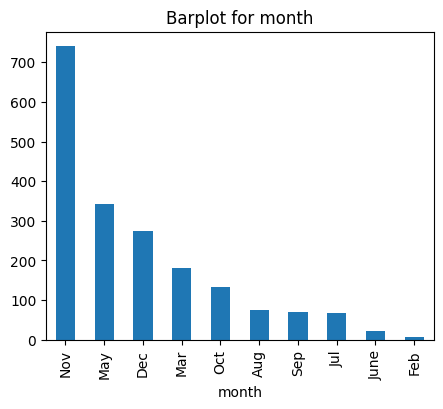

In [24]:
# Plot a bar chart for months
revenue_true_plot.plot_counts('month')

November generates the most sales.

*S2Q1: The count of the operating systems used to visit the site and the percentage of the total*

In [25]:
# Get counts for each operating system
customer_activity_info.get_counts('operating_systems')

Counts for distinct values for operating_systems
operating_systems  counts  percentage
          Windows    6602       53.58
            MACOS    2676       21.72
          Android    2580       20.94
              iOS     385        3.12
         ChromeOS      62        0.50
           Ubuntu       9        0.07
            Other       7        0.06


*S2Q2: The amount of users visiting the site using mobile operating system and desktop operating systems*

Mobile operating systems: 2965
Desktop operating systems: 9356

*S2Q3: The most commonly used browsers and their breakdown on mobile versus desktop*

In [26]:
browsers = pd.DataFrame(customer_activity['browser'].value_counts())
browsers = browsers.reset_index()
browsers.columns = ['browsers', 'counts']
browsers['desktop vs mobile'] = ['desktop', 'desktop', 'desktop', 'desktop', 'desktop', 'mobile', 'desktop',
                    'mobile', 'mobile', 'desktop', 'desktop', 'desktop', 'desktop']
print(browsers.to_string(index=False))

         browsers  counts desktop vs mobile
    Google Chrome    7713           desktop
           Safari    2527           desktop
  Mozilla Firefox     830           desktop
   Microsoft Edge     581           desktop
Internet Explorer     156           desktop
 Samsung Internet     145            mobile
            Opera     136           desktop
          Android     121            mobile
               QQ      53            mobile
   Sogou Explorer      47           desktop
           Yandex       8           desktop
       UC Browser       2           desktop
     Undetermined       2           desktop


*S2Q4: Based on this analysis of what are the most popular operating system, are there any regions where there is a discrepancy in what is popular?*

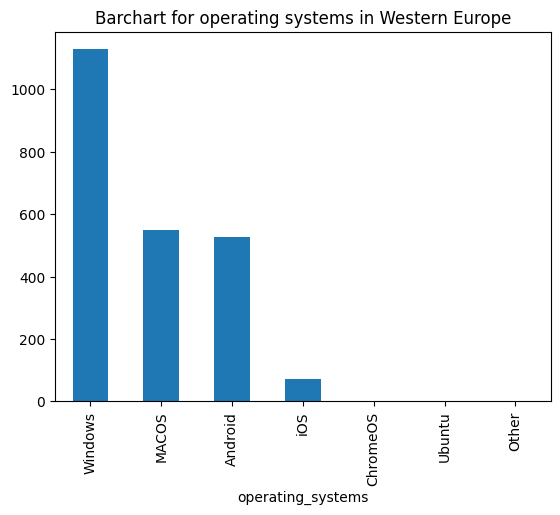

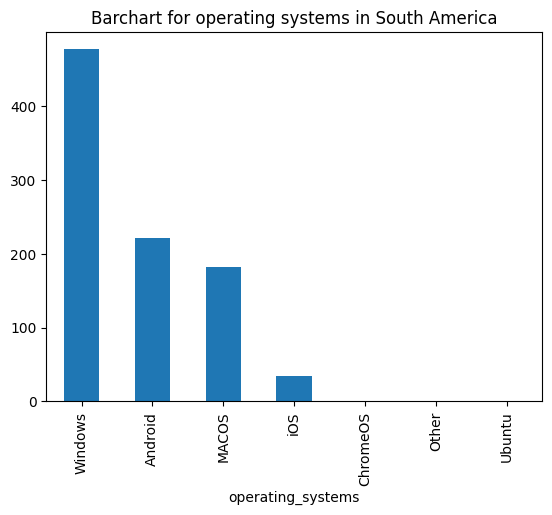

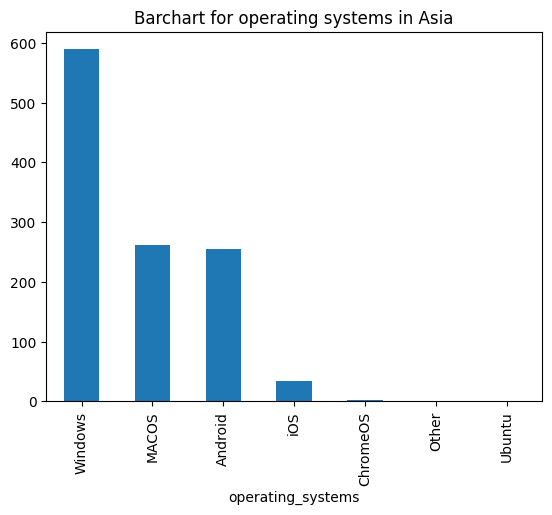

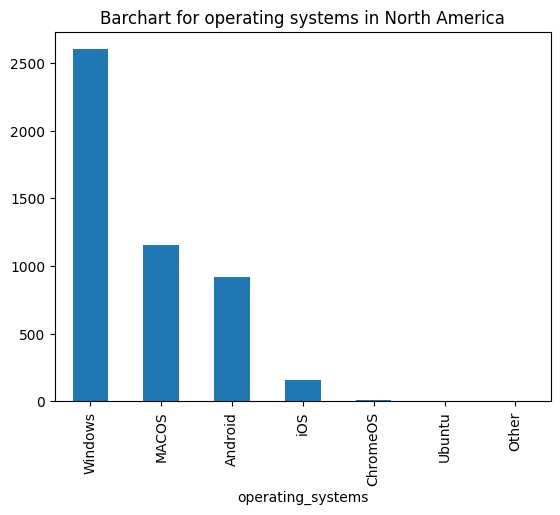

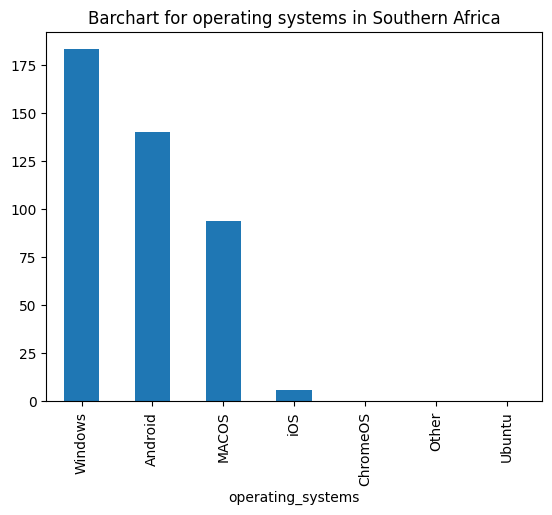

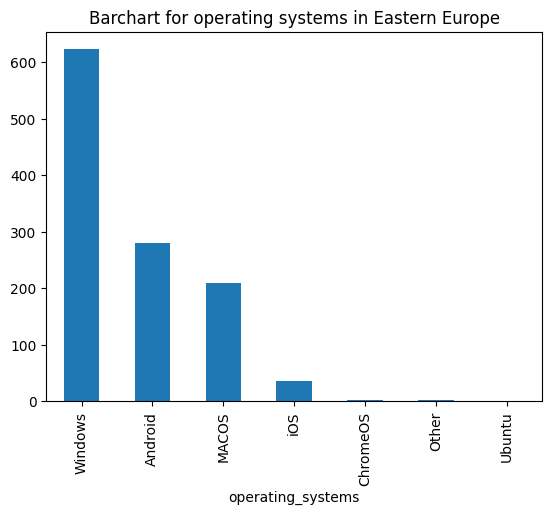

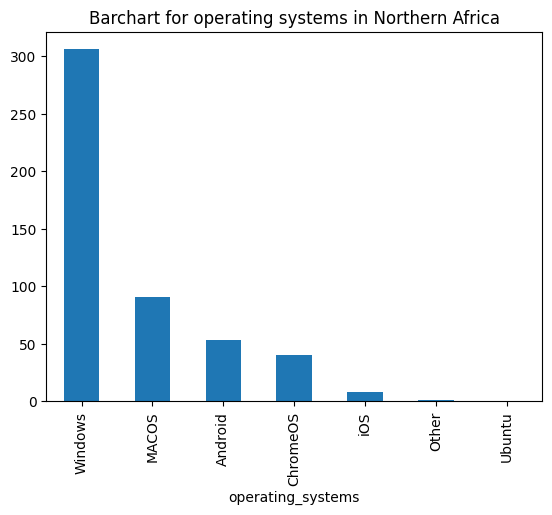

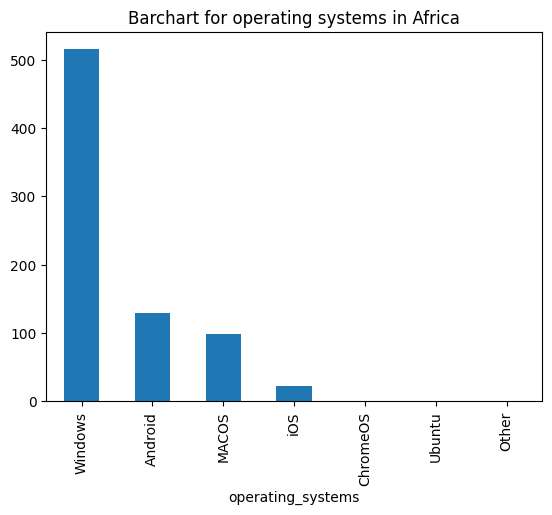

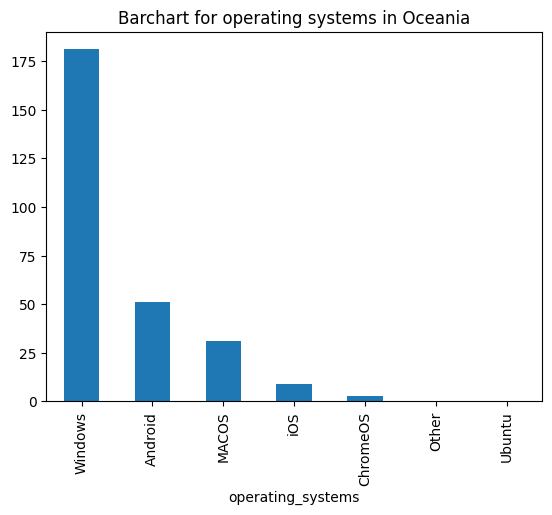

In [27]:
# List all regions
regions_list = list(revenue_true['region'].unique())

# Plot barchart for operating system for each 
for place in regions_list:
    df = customer_activity[customer_activity['region'] == place]
    df['operating_systems'].value_counts().plot(kind = 'bar')
    plt.title(f'Barchart for operating systems in {place}')
    plt.show()

iOS might be having a technical issue in Northern Africa.

*S3Q1: Visualise what traffic is currently generating the most revenue broken down by region*

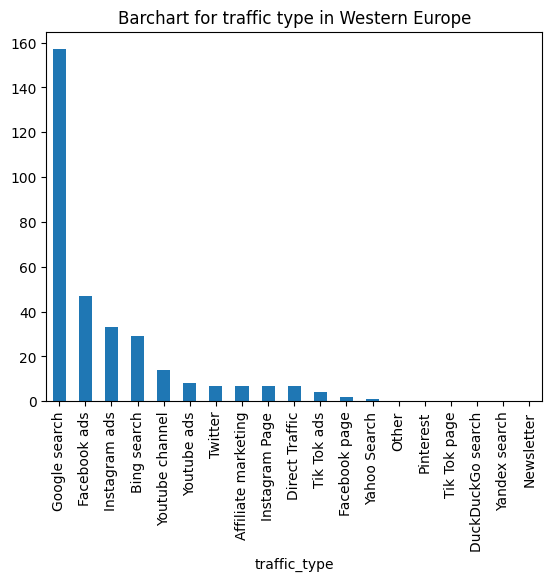

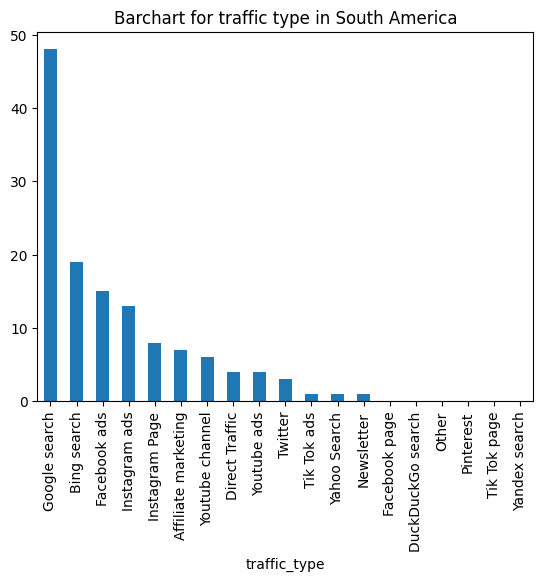

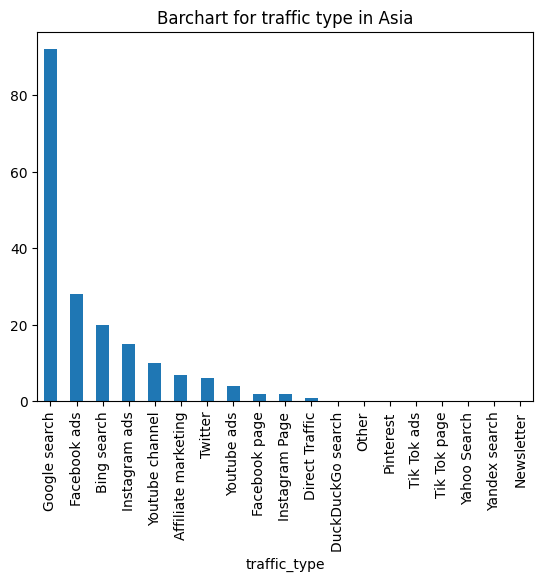

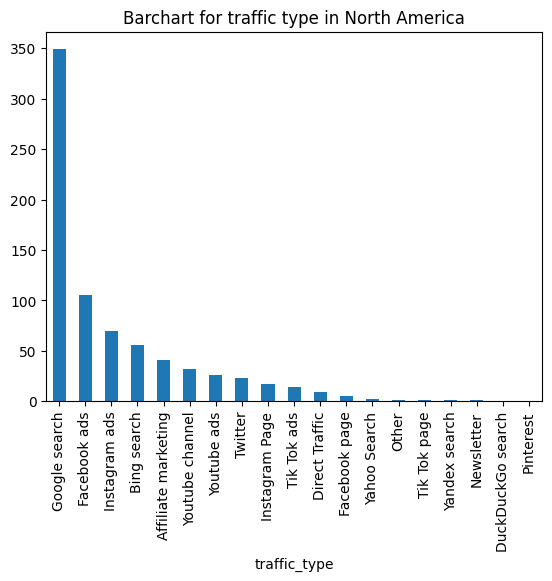

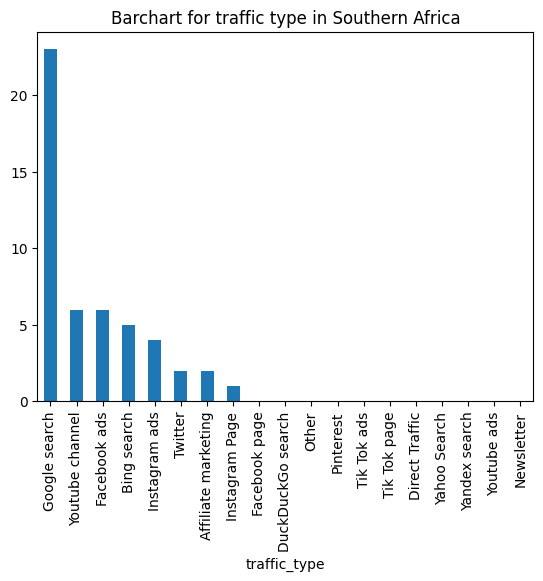

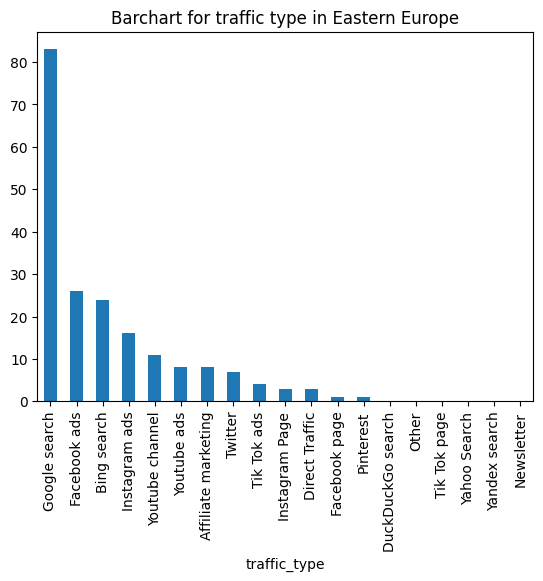

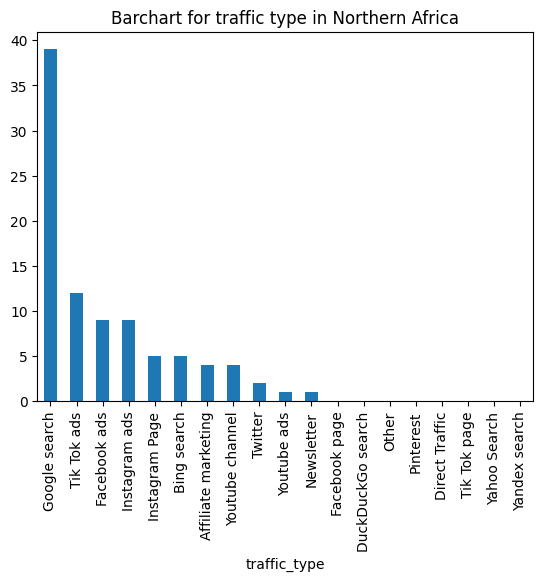

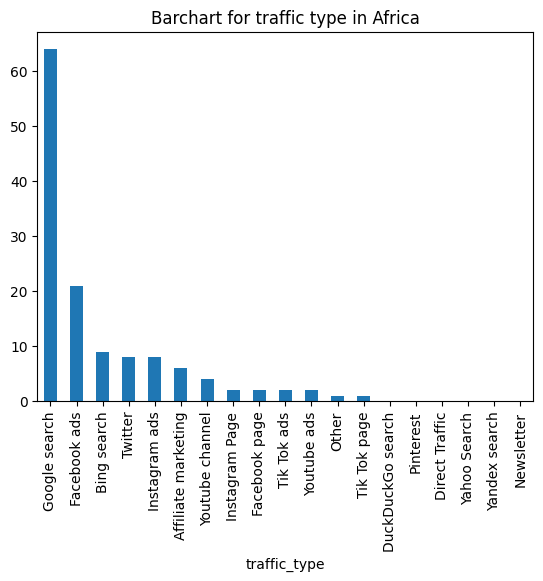

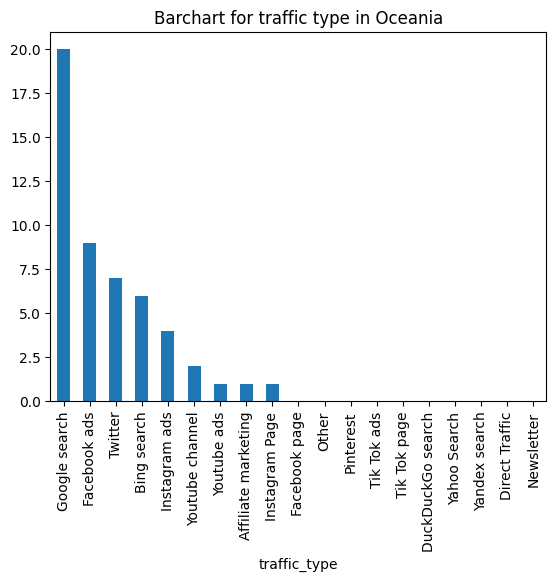

In [28]:
# Plot a bar chart for traffic for each region
for place in regions_list:
    df = revenue_true[revenue_true['region'] == place]
    df['traffic_type'].value_counts().plot(kind = 'bar')
    plt.title(f'Barchart for traffic type in {place}')
    plt.show()

*S3Q2: What traffic has the highest bounce rate? This could indicate that the marketing channels advertisement isn't enticing enough for the customers.*

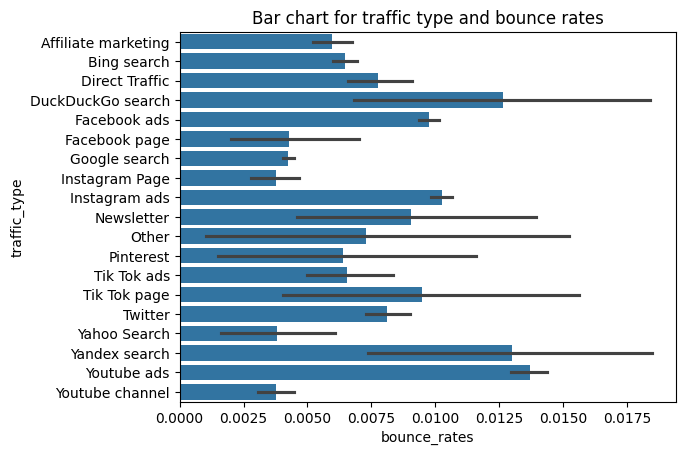

In [29]:
# Plot a barchart to visualise the relationship between bounce rate and traffic type
sns.barplot(y = customer_activity['traffic_type'], x = customer_activity['bounce_rates'])
plt.title('Bar chart for traffic type and bounce rates')
plt.show()

*S3Q3: Check what months have generated the most sales from ads traffic*

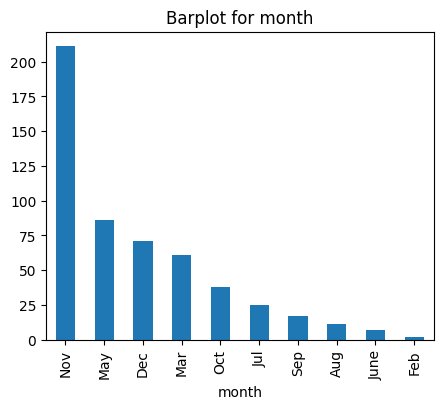

In [30]:
# List traffic types
list(customer_activity['traffic_type'].unique())

# Create a new DataFrame where revenue is True and traffic type is Ads
ads_list = ['Instagram ads', 'Facebook ads', 'Youtube ads', 'Tik Tok ads']
ads_profit_df = revenue_true[revenue_true['traffic_type'].isin(ads_list)]
ads_profit_plotter = plotter.Plotter(ads_profit_df)
ads_profit_plotter.plot_counts('month')

*S4Q1: Which region is currently generating the most/least revenue?*

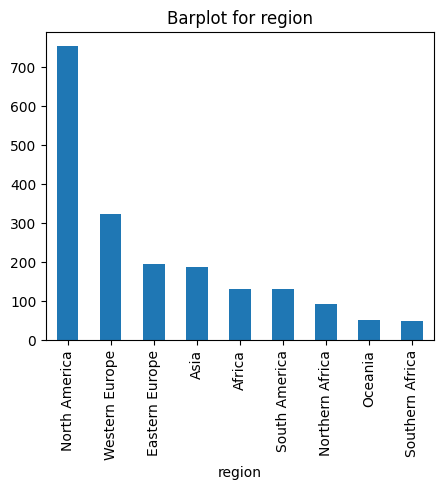

In [31]:
# Plot a bar chart for region where revenue is True
revenue_true_plot.plot_counts('region')

North America is generating the most revenue, Southern Africa is generating the least revenue.

*S4Q2: What percentage of our returning/new customers are making a purchase when they visit the site?*

In [32]:
# For returning customers
returning_df = customer_activity[customer_activity['visitor_type'] == 'Returning_Visitor']
returning_dataframe_info = dataframe_info.DataFrameInfo(returning_df)
print('For returning customers:')
returning_dataframe_info.get_counts('revenue')

# for new customers
new_df = customer_activity[customer_activity['visitor_type'] == 'New_Visitor']
new_dataframe_info = dataframe_info.DataFrameInfo(new_df)
print('\n')
print('For new customers:')
new_dataframe_info.get_counts('revenue')


For returning customers:
Counts for distinct values for revenue
 revenue  counts  percentage
   False    9163       85.78
    True    1519       14.22


For new customers:
Counts for distinct values for revenue
 revenue  counts  percentage
   False    1191       75.86
    True     379       24.14


14% of returning customers and 24% of new customers are making a purchase when they visit the site.

*S4Q3: Are sales being made more on weekends comparatively to weekdays?*

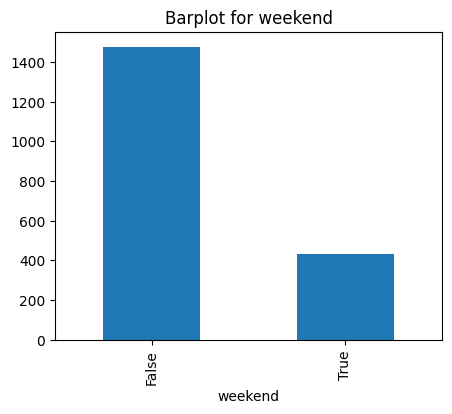

In [33]:
# Plot a bar chart for the weekend column where revenue is True
revenue_true_plot.plot_counts('weekend')

No, the amount of sales is small for the activities that took place at weekends only.

*S4Q4: Which months have been the most effective for generating sales?*

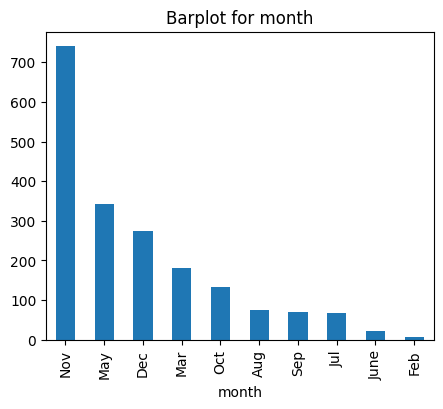

In [34]:
# Plot a bar chart for months
revenue_true_plot.plot_counts('month')

November has been the most successful for generating sales.

*S4Q5: Is direct/social or advertising traffic contributing heavily to sales?*

In [35]:
# For a DataFrame where revenue is True, get counts for each traffic type
revenue_true_info = dataframe_info.DataFrameInfo(revenue_true)
revenue_true_info.get_counts('traffic_type')

Counts for distinct values for traffic_type
       traffic_type  counts  percentage
      Google search     875       45.84
       Facebook ads     266       13.93
        Bing search     173        9.06
      Instagram ads     172        9.01
    Youtube channel      89        4.66
Affiliate marketing      83        4.35
            Twitter      65        3.40
        Youtube ads      54        2.83
     Instagram Page      46        2.41
        Tik Tok ads      37        1.94
     Direct Traffic      24        1.26
      Facebook page      12        0.63
       Yahoo Search       4        0.21
         Newsletter       3        0.16
              Other       2        0.10
       Tik Tok page       2        0.10
          Pinterest       1        0.05
      Yandex search       1        0.05
  DuckDuckGo search       0        0.00


Direct traffic is contributing to only 1% of the total sales. Advertising is contributing to 28% of the total sales. Social is contributing to 7% of the total.